In [7]:
import at
import numpy as np
from pySC.correction.bba import trajectory_bba, fake_bba

from at import Lattice
from pySC.utils.at_wrapper import atloco
from pySC.core.simulated_commissioning import SimulatedCommissioning
from pySC.correction.orbit_trajectory import SCfeedbackFirstTurn, SCfeedbackStitch, SCfeedbackRun, SCfeedbackBalance
from pySC.core.beam import bpm_reading, beam_transmission
from pySC.correction.tune import tune_scan
from pySC.lattice_properties.response_model import SCgetModelRM, SCgetModelDispersion
from pySC.utils.sc_tools import SCgetOrds, SCgetPinv
from pySC.correction.loco_wrapper import (loco_model, loco_fit_parameters, apply_lattice_correction, loco_measurement,
                                          loco_bpm_structure, loco_cm_structure)
from pySC.plotting.plot_phase_space import plot_phase_space
from pySC.plotting.plot_support import plot_support
from pySC.plotting.plot_lattice import plot_lattice
from pySC.core.lattice_setting import switch_cavity_and_radiation
from pySC.correction.rf import correct_rf_phase, correct_rf_frequency, phase_and_energy_error
from pySC.utils import logging_tools

LOGGER = logging_tools.get_logger(__name__)


def create_at_lattice() -> Lattice:
    def _marker(name):
        return at.Marker(name, PassMethod='IdentityPass')
    qf = at.Quadrupole('QF', 0.5, 1.2, PassMethod='StrMPoleSymplectic4RadPass')
    qd = at.Quadrupole('QD', 0.5, -1.2, PassMethod='StrMPoleSymplectic4RadPass')
    sf = at.Sextupole('SF', 0.1, 6.0487, PassMethod='StrMPoleSymplectic4RadPass')
    sd = at.Sextupole('SD', 0.1, -9.5203, PassMethod='StrMPoleSymplectic4RadPass')
    bend = at.Bend('BEND', 1, 2 * np.pi / 40, PassMethod='BndMPoleSymplectic4RadPass')
    d2 = at.Drift('Drift', 0.25)
    d3 = at.Drift('Drift', 0.2)
    BPM= at.Monitor('BPM')

    cell = at.Lattice([d2, _marker('SectionStart'), _marker('GirderStart'), bend, d3, sf, d3, _marker('GirderEnd'),
                       _marker('GirderStart'), BPM, qf, d2, d2, bend, d3, sd, d3, qd, d2, _marker('BPM'),
                       _marker('GirderEnd'), _marker('SectionEnd')], name='Simple FODO cell', energy=2.5E9)
    new_ring = at.Lattice(cell * 20)
    rfc = at.RFCavity('RFCav', energy=2.5E9, voltage=2e6, frequency=500653404.8599995, harmonic_number=167, length=0)
    new_ring.insert(0, rfc)
    new_ring.enable_6d()
    at.set_cavity_phase(new_ring)
    at.set_rf_frequency(new_ring)
    return new_ring


if __name__ == "__main__":
    ring = at.Lattice(create_at_lattice())
    LOGGER.info(f"{len(ring)=}")
    SC = SimulatedCommissioning(ring)
    # at.summary(ring)
    ords = SCgetOrds(SC.RING, 'BPM')
    SC.register_bpms(ords, CalError=5E-2 * np.ones(2),  # x and y, relative
                     Offset=500E-6 * np.ones(2),  # x and y, [m]
                     Noise=10E-6 * np.ones(2),  # x and y, [m]
                     NoiseCO=1E-6 * np.ones(2),  # x and y, [m]
                     Roll=1E-3)  # az, [rad]
    ords = SCgetOrds(SC.RING, 'QF')
    SC.register_magnets(ords, HCM=1E-3,  # [rad]
                        CalErrorB=np.array([5E-2, 1E-3]),  # relative
                        MagnetOffset=200E-6 * np.array([1, 1, 0]),  # x, y and z, [m]
                        MagnetRoll=200E-6 * np.array([1, 0, 0]))  # az, ax and ay, [rad]
    ords = SCgetOrds(SC.RING, 'QD')
    SC.register_magnets(ords, VCM=1E-3,  # [rad]
                        CalErrorA=np.array([5E-2, 0]),  # relative
                        CalErrorB=np.array([0, 1E-3]),  # relative
                        MagnetOffset=200E-6 * np.array([1, 1, 0]),  # x, y and z, [m]
                        MagnetRoll=200E-6 * np.array([1, 0, 0]))  # az, ax and ay, [rad]
    ords = SCgetOrds(SC.RING, 'BEND')
    SC.register_magnets(ords,
                        BendingAngle=1E-3,  # relative
                        MagnetOffset=200E-6 * np.array([1, 1, 0]),  # x, y and z, [m]
                        MagnetRoll=200E-6 * np.array([1, 0, 0]))  # az, ax and ay, [rad]
    ords = SCgetOrds(SC.RING, 'SF|SD')
    SC.register_magnets(ords,
                        SkewQuad=0.1,  # [1/m]
                        CalErrorA=np.array([0, 1E-3, 0]),  # relative
                        CalErrorB=np.array([0, 0, 1E-3]),  # relative
                        MagnetOffset=200E-6 * np.array([1, 1, 0]),  # x, y and z, [m]
                        MagnetRoll=200E-6 * np.array([1, 0, 0]))  # az, ax and ay, [rad]
    ords = SCgetOrds(SC.RING, 'RFCav')
    SC.register_cavities(ords, FrequencyOffset=5E3,  # [Hz]
                         VoltageOffset=5E3,  # [V]
                         TimeLagOffset=0.5)  # [m]
    ords = np.vstack((SCgetOrds(SC.RING, 'GirderStart'), SCgetOrds(SC.RING, 'GirderEnd')))
    SC.register_supports(ords, "Girder",
                         Offset=100E-6 * np.array([1, 1, 0]),  # x, y and z, [m]
                         Roll=200E-6 * np.array([1, 0, 0]))  # az, ax and ay, [rad]
    ords = np.vstack((SCgetOrds(SC.RING, 'SectionStart'), SCgetOrds(SC.RING, 'SectionEnd')))
    SC.register_supports(ords, "Section",
                           Offset=100E-6 * np.array([1, 1, 0]))  # x, y and z, [m]
    SC.INJ.beamSize = np.diag(np.array([200E-6, 100E-6, 100E-6, 50E-6, 1E-3, 1E-4]) ** 2)
    SC.SIG.randomInjectionZ = np.array([1E-4, 1E-5, 1E-4, 1E-5, 1E-4, 1E-4])  # [m; rad; m; rad; rel.; m]
    SC.SIG.staticInjectionZ = np.array([1E-3, 1E-4, 1E-3, 1E-4, 1E-3, 1E-3])  # [m; rad; m; rad; rel.; m]
    SC.SIG.Circumference = 2E-4  # relative
    SC.INJ.beamLostAt = 0.6  # relative
    for ord in SCgetOrds(SC.RING, 'Drift'):
        SC.RING[ord].EApertures = 13E-3 * np.array([1, 1])  # [m]
    for ord in SCgetOrds(SC.RING, 'QF|QD|BEND|SF|SD'):
        SC.RING[ord].EApertures = 10E-3 * np.array([1, 1])  # [m]
    SC.RING[SC.ORD.Magnet[50]].EApertures = np.array([6E-3, 3E-3])  # [m]

    plot_lattice(SC, s_range=np.array([0, 20]))
    SC.apply_errors()
    SC.verify_structure()
    plot_support(SC)

    SC.RING = switch_cavity_and_radiation(SC.RING, 'cavityoff')
    sextOrds = SCgetOrds(SC.RING, 'SF|SD')
    SC.set_magnet_setpoints(sextOrds, 0.0, False, 2, method='abs')
    RM1 = SCgetModelRM(SC, SC.ORD.BPM, SC.ORD.CM, nTurns=1)
    RM2 = SCgetModelRM(SC, SC.ORD.BPM, SC.ORD.CM, nTurns=2)
    Minv1 = SCgetPinv(RM1, alpha=50)
    Minv2 = SCgetPinv(RM2, alpha=50)
    SC.INJ.nParticles = 1
    SC.INJ.nTurns = 1
    SC.INJ.nShots = 1
    SC.INJ.trackMode = 'TBT'
    eps = 5E-4  # Noise level
    bpm_reading(SC)
    SC = SCfeedbackFirstTurn(SC, Minv1)

    SC.INJ.nTurns = 2
    SC = SCfeedbackStitch(SC, Minv2, nBPMs=3, maxsteps=20)
    # SC = SCfeedbackRun(SC, Minv2, target=300E-6, maxsteps=30, eps=eps)
    SC = SCfeedbackBalance(SC, Minv2, maxsteps=32, eps=eps)

    # plot_cm_strengths(SC)
    # Performing trajectory BBA
    SC.INJ.nParticles = 1
    quadOrds = np.tile(SCgetOrds(SC.RING, 'QF|QD'), (2, 1))
    BPMords = np.tile(SC.ORD.BPM, (2, 1))
    SC, bba_offsets, bba_offset_errors = trajectory_bba(SC, BPMords, quadOrds, q_ord_phase=SCgetOrds(SC.RING, 'QF|QD')[0],
                                                        q_ord_setpoints=np.array([0.8, 0.9, 1.0, 1.1, 1.2]),
                                                        magnet_strengths=np.array([0.8, 0.9, 1.0, 1.1, 1.2]),
                                                        dipole_compensation=True, plot_results=True)

    # Turning on the sextupoles
    for rel_setting in np.linspace(0.1, 1, 5):
        SC.set_magnet_setpoints(sextOrds, rel_setting, False, 2, method='rel')
        try:
            SC = SCfeedbackBalance(SC, Minv2, maxsteps=32, eps=eps)
        except RuntimeError:
            pass

    SC.RING = switch_cavity_and_radiation(SC.RING, 'cavityon')

    # Plot initial phasespace
    plot_phase_space(SC, nParticles=10, nTurns=100)

    # RF cavity correction
    for nIter in range(2):
        SC.INJ.nTurns = 5
        SC = correct_rf_phase(SC, n_steps=25, plot_results=False, plot_progress=False)
        SC.INJ.nTurns = 15
        SC = correct_rf_frequency(SC, n_steps=15, f_range=4E3 * np.array([-1, 1]), plot_results=False,
                                  plot_progress=False)

    # Plot phasespace after RF correction
    plot_phase_space(SC, nParticles=10, nTurns=100)
    [maxTurns, lostCount] = beam_transmission(SC, nParticles=100, nTurns=10)

    # Faking-BBA
    quadOrds = np.tile(SCgetOrds(SC.RING, 'QF|QD'), (2, 1))
    BPMords = np.tile(SC.ORD.BPM, (2, 1))
    SC = fake_bba(SC, BPMords, quadOrds, fake_offset=np.array([50E-6, 50E-6]))

    # Orbit correction
    SC.INJ.trackMode = 'ORB'
    MCO = SCgetModelRM(SC, SC.ORD.BPM, SC.ORD.CM, trackMode='ORB')
    eta = SCgetModelDispersion(SC, SC.ORD.BPM, SC.ORD.RF)

    for alpha in range(10, 0, -1):
        MinvCO = SCgetPinv(np.column_stack((MCO, 1E8 * eta)), alpha=alpha)
        try:
            CUR = SCfeedbackRun(SC, MinvCO, target=0, maxsteps=50, scaleDisp=1E8)
        except RuntimeError:
            break
        B0rms = np.sqrt(np.mean(np.square(bpm_reading(SC)[0]), axis=1))
        Brms = np.sqrt(np.mean(np.square(bpm_reading(CUR)[0]), axis=1))
        if np.mean(B0rms) < np.mean(Brms):
            break
        SC = CUR
    SC.RING = switch_cavity_and_radiation(SC.RING, 'cavityon')
    plot_phase_space(SC, nParticles=10, nTurns=1000)
    maxTurns, lostCount = beam_transmission(SC, nParticles=100, nTurns=200, plot=True)
    SC, _, _, _ = tune_scan(SC, np.vstack((SCgetOrds(SC.RING, 'QF'), SCgetOrds(SC.RING, 'QD'))),
                            np.outer(np.ones(2), 1 + np.linspace(-0.01, 0.01, 51)), do_plot=False, nParticles=100,
                            nTurns=200)



ImportError: cannot import name 'trajectory_bba' from 'pySC.correction.bba' (c:\users\musa\desktop\pysc\pySC\correction\bba.py)

In [5]:
from pySC.correction.loco_modules import *
from matplotlib import pyplot as plt
CorOrds = SC.ORD.CM
CAVords = SCgetOrds(SC.RING, 'RFC')
quadsOrds = [SCgetOrds(SC.RING, 'QF'), SCgetOrds(SC.RING, 'QD')]
CAVords = SCgetOrds(SC.RING, 'RFCav')
sextOrds = SCgetOrds(SC.RING, 'SF|SD')
skewOrds =  SC.ORD.SkewQuad
CMstep =  1.e-4 #correctors change [rad]
dk = 1.e-4 #quads change
RFstep = 1e3

orbit_response_matrix_model = SCgetModelRM(SC, SC.ORD.BPM, CorOrds, trackMode='ORB', useIdealRing=True, dkick= CMstep)
ModelDispersion = SCgetModelDispersion(SC, SC.ORD.BPM, CAVords, trackMode='ORB', Z0=np.zeros(6), nTurns=1, rfStep=RFstep, useIdealRing=True)

J =   generatingJacobian(SC, orbit_response_matrix_model, CMstep, CorOrds, SC.ORD.BPM, np.concatenate(quadsOrds), dk, debug=True, trackMode='ORB', useIdealRing=False,skewness = False, order=1, method='add', includeDispersion=False, rf_step=RFstep, cav_ords=CAVords, full_jacobian = True )

#print(J.shape)
#,full_jacobian=False
errq =[]
for i in np.concatenate(quadsOrds):
    errq.append(SC.RING[i].K- SC.IDEALRING[i].K)

err_cor=[]
for i in CorOrds[0]:
    err_cor.append(SC.RING[i].CalErrorB[0])
for i in CorOrds[1]:
    err_cor.append(SC.RING[i].CalErrorA[0])
orbit_response_matrix_measured = SCgetMeasurRM(SC, SC.ORD.BPM, CorOrds, CMstep)

err_bpms=[]
for i in SC.ORD.BPM:
    err_bpms.append(SC.RING[i].CalError[0])
for i in SC.ORD.BPM:
    err_bpms.append(SC.RING[i].CalError[1])

SC.INJ.trackMode = 'ORB'
bpm_nois, b = bpm_reading(SC, SC.ORD.BPM, calculate_errors=True)

sigma1 =[]
for i in range(len(SC.ORD.BPM)):
    sigma1.append(bpm_nois[1][i])
for i in range(len(SC.ORD.BPM)):
    sigma1.append(bpm_nois[1][i])
sigma_ = np.array(sigma1)

min_value = np.min(abs(sigma_))
sigma_ /= min_value
sigma = sigma_

W = 1/sigma
W = np.diag(1 / (sigma)** 2)

   INFO | Calculating model response matrix | lattice_properties.response_model
   INFO | Calculating model dispersion | lattice_properties.response_model
   INFO | Calculating Measure response matrix | correction.loco_modules


AttributeError: trackMode property has to be one of ('TBT', 'ORB', 'PORB')

In [9]:
print('LOCO correction')

initial_guess = np.zeros(len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)) +  len(SC.ORD.BPM) *2)
initial_guess[0:len(np.concatenate(quadsOrds))] = 1e-6
initial_guess[len(np.concatenate(quadsOrds)):len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds))] = 1e-6
initial_guess[len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)):] = 1e-6
lengths = [len(np.concatenate(quadsOrds)),len(np.concatenate(CorOrds)),  len(SC.ORD.BPM) *2]
including_fit_parameters = ['quads', 'cor', 'bpm']

fit_parameters, params_to_check  = loco_correction(lambda delta_params: objective(delta_params, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters, W),initial_guess,orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths,including_fit_parameters,W
                             , verbose=2)

dg  = fit_parameters.x[0:len(np.concatenate(quadsOrds))]
dx = fit_parameters.x[len(np.concatenate(quadsOrds)):len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds))]
dy = fit_parameters.x[len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)):]
print('Fit result:', params_to_check, 'Cost function:', fit_parameters.cost)

LOCO correction
`ftol` termination condition is satisfied.
Function evaluations 2094, initial cost 5.6842e+01, final cost 1.7840e-01, first-order optimality 5.93e-04.
Fit result: {'r_squared': 0.9932518296763553, 'rmse': 0.2203687855335645} Cost function: 0.1783988285679413


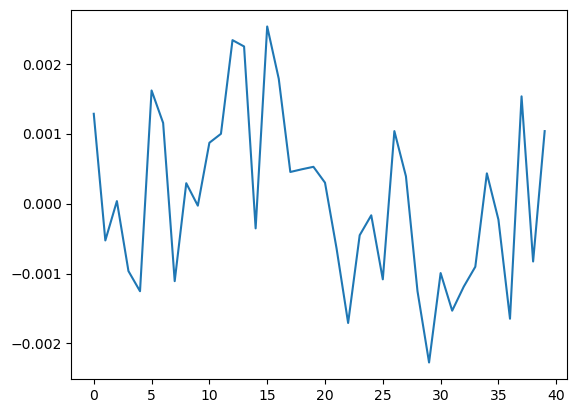

In [10]:
plt.plot(errq-dg)

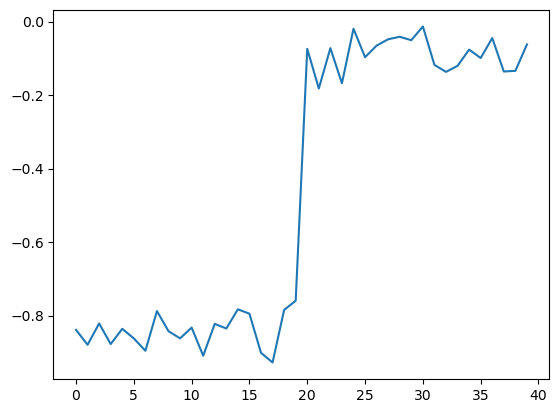

In [11]:
plt.plot(err_cor-dx)


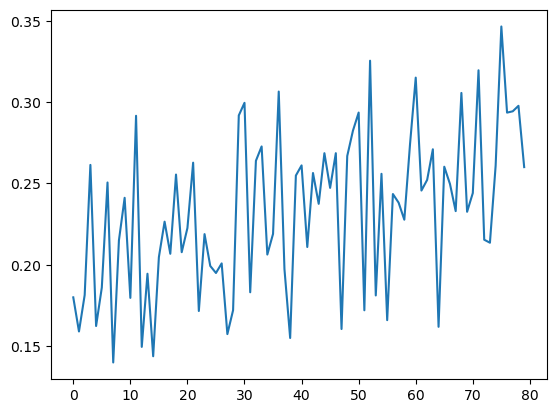

In [12]:
plt.plot(err_bpms-dy)
